In [60]:
import os
import sys
from typing import List
import numpy as np
import faiss

ROOT_DIR = os.path.dirname(os.getcwd())
sys.path.append(ROOT_DIR)

from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

from utils import *

In [61]:
scores = {}

In [62]:
df = prepare_dataset()

Loading datasets: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


In [63]:
texts = df['abstract'].to_list()
labels = df['label'].to_list()

In [64]:
class EmbeddingDeduplicatorCPU:
    '''
    A class to deduplicate text embeddings using FAISS.
    '''
    def __init__(self, model_name: str = 'sentence-transformers/all-MiniLM-L6-v2', dimension: int = 384, top_k: int = 3, threshold: float = 0.85, bacth_size: int = 32):
        self.model = SentenceTransformer(model_name, device="cpu", cache_folder='.cache')
        self.dimension = dimension
        self.top_k = top_k
        self.threshold = threshold
        self.batch_size = bacth_size
    
    def predict(self, texts: List[str]) -> np.ndarray:
        embeddings = self.model.encode(texts, show_progress_bar=False, normalize_embeddings=True, batch_size=self.batch_size)
        
        index = faiss.IndexFlatIP(self.dimension)
        index.add(embeddings)

        similarities, neighbors = index.search(embeddings, self.top_k)

        duplicates = set()

        for i in range(len(texts)):
            for j, sim in zip(neighbors[i][1:], similarities[i][1:]):
                if sim > self.threshold:
                        duplicates.add(i)
                        duplicates.add(j)

        indices = np.zeros(len(texts), dtype=int)
        indices[list(duplicates)] = 1
        return indices

In [65]:
deduplicator = EmbeddingDeduplicatorCPU(
    model_name='sentence-transformers/paraphrase-MiniLM-L3-v2',
    dimension=384,
    threshold=0.96,
    top_k=3,
    bacth_size=256
)
benchmark = Benchmark(deduplicator)
metrics_cpu = benchmark.evaluate(texts, labels, verbose=True)

Summary:
Metric                        Value
-----------------------------------
Accuracy                    0.92749
Precision                   0.98256
Recall                      0.87043
F1                          0.92310
Prediction_time_sec        44.94455
Samples                  9347.00000
Duplicates               4623.00000


In [66]:
class EmbeddingDeduplicatorGPU:
    '''
    A class to deduplicate text embeddings using FAISS.
    '''
    def __init__(self, model_name: str = 'sentence-transformers/all-MiniLM-L6-v2', dimension: int = 384, top_k: int = 3, threshold: float = 0.85, bacth_size: int = 32):
        self.model = SentenceTransformer(model_name, device="cuda", cache_folder='.cache')
        self.dimension = dimension
        self.top_k = top_k
        self.threshold = threshold
        self.batch_size = bacth_size
    
    def predict(self, texts: List[str]) -> np.ndarray:
        embeddings = self.model.encode(texts, show_progress_bar=False, normalize_embeddings=True, batch_size=self.batch_size)
        
        index = faiss.IndexFlatIP(self.dimension)
        index.add(embeddings)

        similarities, neighbors = index.search(embeddings, self.top_k)

        duplicates = set()

        for i in range(len(texts)):
            for j, sim in zip(neighbors[i][1:], similarities[i][1:]):
                if sim > self.threshold:
                        duplicates.add(i)
                        duplicates.add(j)

        indices = np.zeros(len(texts), dtype=int)
        indices[list(duplicates)] = 1
        return indices

In [67]:
deduplicator = EmbeddingDeduplicatorGPU(
    model_name='sentence-transformers/paraphrase-MiniLM-L3-v2',
    dimension=384,
    threshold=0.96,
    top_k=3,
    bacth_size=256
)
benchmark = Benchmark(deduplicator)
metrics_gpu = benchmark.evaluate(texts, labels, verbose=True)

Summary:
Metric                        Value
-----------------------------------
Accuracy                    0.92749
Precision                   0.98256
Recall                      0.87043
F1                          0.92310
Prediction_time_sec         7.87459
Samples                  9347.00000
Duplicates               4623.00000


In [68]:
scores["Intel Core\nUltra 7-155H"] = metrics_cpu["prediction_time_sec"]
scores["Nvidia GeForce\nRTX 4060 35W"] = metrics_gpu["prediction_time_sec"]
scores["Apple M4"] = 6.00272

<function matplotlib.pyplot.show(close=None, block=None)>

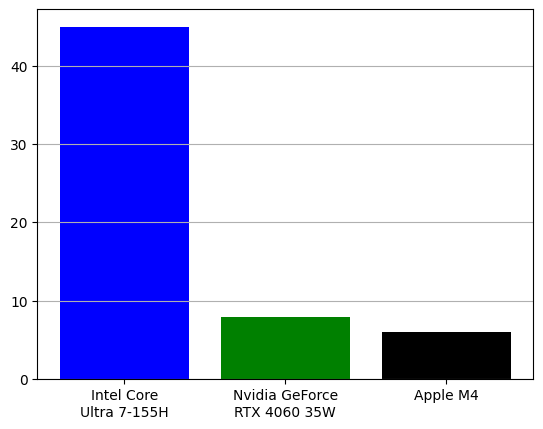

In [69]:
plt.grid(axis='y')
plt.bar(list(scores.keys()), list(scores.values()), color=['blue', 'green', 'black'])
plt.show